## Global settings and imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
#import optuna
from tqdm import tqdm
import torch.optim as optim

from utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
    DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL,
    DEFAULT_CATEGORY_STR_COL,
    DEFAULT_TOPICS_COL,
    DEFAULT_CATEGORY_STR_COL,
    DEFAULT_TOPICS_COL,
    DEFAULT_TOTAL_PAGEVIEWS_COL,
    DEFAULT_TOTAL_READ_TIME_COL,
    DEFAULT_SENTIMENT_SCORE_COL,
)

from utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)
from evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore
from utils._articles import convert_text2encoding_with_transformers
from utils._polars import concat_str_columns, slice_join_dataframes
from utils._articles import create_article_id_to_value_mapping
from utils._nlp import get_transformers_word_embeddings, generate_embeddings_with_transformers
from utils._python import write_submission_file, rank_predictions_by_score
from models_pytorch.model_config import hparams_nrms

from models_pytorch.nrms import NRMSModel
from models_pytorch.NRMSDocVecModel import NRMSDocVecModel

from transformers import AutoTokenizer, AutoModel
from models_pytorch.dataloader import NRMSDataSet

# Check Python version
print(f"Python version: {sys.version.split()[0]}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.12.1
PyTorch version: 2.5.1+cu121
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3070
Number of GPUs available: 1


## Looking at behaviours and history

## Download and load data

In [2]:
PATH = Path("./ebnerd_small")  # Base path for your data directory
print(PATH)


ebnerd_small


In [3]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
]
HISTORY_SIZE = 50 # TODO: History size. 
FRACTION = 0.2

df_train = (
    ebnerd_from_path(PATH.joinpath("train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath("validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
df_train.head(2)

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,impression_time,labels
u32,list[i32],list[i64],list[i64],u32,datetime[μs],list[i8]
2498520,"[9759241, 9759142, … 9770741]","[9772099, 9772443, … 9772750]",[9772443],337281027,2023-05-19 20:34:48,"[0, 1, … 0]"
603561,"[9765172, 9765551, … 9769553]","[9778827, 9778668, … 9778769]",[9778666],279245246,2023-05-24 08:54:32,"[0, 0, … 0]"


In [4]:
df_train = df_train.with_columns([
    (
        (pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL)
        .cast(pl.Datetime)
        .dt.epoch(time_unit='s') / 3600)
        .cast(pl.Int64)
    ).alias(DEFAULT_IMPRESSION_TIMESTAMP_COL)
])

df_validation = df_validation.with_columns([
    (
        (pl.col(DEFAULT_IMPRESSION_TIMESTAMP_COL)
        .cast(pl.Datetime)
        .dt.epoch(time_unit='s') / 3600)
        .cast(pl.Int64)
    ).alias(DEFAULT_IMPRESSION_TIMESTAMP_COL)
])

In [5]:
df_train.head(5)

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,impression_time,labels
u32,list[i32],list[i64],list[i64],u32,i64,list[i8]
2498520,"[9759241, 9759142, … 9770741]","[9772099, 9772443, … 9772750]",[9772443],337281027,467924,"[0, 1, … 0]"
603561,"[9765172, 9765551, … 9769553]","[9778827, 9778668, … 9778769]",[9778666],279245246,468032,"[0, 0, … 0]"
329699,"[9766592, 9759345, … 9742173]","[9771859, 9771859, … 9773015]",[9761859],142964085,467934,"[0, 0, … 0]"
1168921,"[9767772, 9767746, … 9663715]","[9761926, 8169191, … 9771896]",[9771896],263407383,467908,"[0, 0, … 1]"
1012106,"[9752962, 9749760, … 9754730]","[9774618, 9120051, … 9774527]",[9774527],316436953,467966,"[0, 0, … 1]"


In [6]:
df_validation.head(5)

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,impression_time,labels
u32,list[i32],list[i32],list[i32],u32,i64,list[i8]
1582341,"[9753518, 9752685, … 9756397]","[9704868, 9789704, … 9717601]",[9789710],150364157,468203,"[0, 0, … 0]"
1748668,"[9778842, 9779019, … 9779968]","[9780498, 9780860, … 9780514]",[9779779],412610146,468060,"[0, 0, … 0]"
2199962,"[9778902, 9777397, … 9779263]","[9400164, 9780482, … 9780498]",[9780428],525133049,468060,"[0, 0, … 0]"
1959613,"[9775419, 9775402, … 9779738]","[9785718, 9785742, … 9785434]",[9785732],73604021,468182,"[0, 0, … 0]"
612674,"[9776023, 9665220, … 9778902]","[9781158, 9781362, … 9781057]",[9779225],121362715,468063,"[0, 0, … 0]"


In [7]:
def calculate_average_length(df, column):
    total_length = sum(len(row) for row in df[column])
    average_length = total_length / len(df)
    return average_length

# Calculate average length for df_train
average_length_inview_train = calculate_average_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_train: {average_length_inview_train}")

# Calculate average length for df_validation
average_length_inview_validation = calculate_average_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_validation: {average_length_inview_validation}")

Average length of article_ids_inview in df_train: 5.0
Average length of article_ids_inview in df_validation: 11.97173455414989


In [8]:
# Function to find the maximum length of arrays in a column
def find_max_length(df, column):
    max_length = 0
    for row in df[column]:
        max_length = max(max_length, len(row))
    return max_length

# Find the longest inview article length in df_train
max_inview_length_train = find_max_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)

# Find the longest inview article length in df_validation
max_inview_length_validation = find_max_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)

print(f"Longest inview article length in df_train: {max_inview_length_train}")
print(f"Longest inview article length in df_validation: {max_inview_length_validation}")

max_history_length_train = find_max_length(df_train, DEFAULT_HISTORY_ARTICLE_ID_COL)
max_history_length_validation = find_max_length(df_validation, DEFAULT_HISTORY_ARTICLE_ID_COL)

print(f"Longest history length in df_train: {max_history_length_train}")
print(f"Longest history length in df_validation: {max_history_length_validation}")

Longest inview article length in df_train: 5
Longest inview article length in df_validation: 89
Longest history length in df_train: 50
Longest history length in df_validation: 50


In [9]:
# Function to filter rows with exactly one clicked article
def filter_rows_with_one_clicked_article(df, clicked_articles_col):
    # Manually filter rows where the array has exactly one element
    filtered_rows = []
    for row in df.iter_rows(named=True):
        if len(row[clicked_articles_col]) == 1:
            filtered_rows.append(row)
    return pl.DataFrame(filtered_rows)


# Filter rows in df_train and df_validation
df_train = filter_rows_with_one_clicked_article(df_train, DEFAULT_CLICKED_ARTICLES_COL)
df_validation = filter_rows_with_one_clicked_article(df_validation, DEFAULT_CLICKED_ARTICLES_COL)

# Print the results
print(f"Number of rows with exactly one clicked article in df_train: {df_train.shape[0]}")
print(f"Number of rows with exactly one clicked article in df_validation: {df_validation.shape[0]}")


Number of rows with exactly one clicked article in df_train: 46855
Number of rows with exactly one clicked article in df_validation: 48639


In [10]:
df_validation.head()

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,impression_time,labels
i64,list[i64],list[i64],list[i64],i64,i64,list[i64]
1582341,"[9753518, 9752685, … 9756397]","[9704868, 9789704, … 9717601]",[9789710],150364157,468203,"[0, 0, … 0]"
1748668,"[9778842, 9779019, … 9779968]","[9780498, 9780860, … 9780514]",[9779779],412610146,468060,"[0, 0, … 0]"
2199962,"[9778902, 9777397, … 9779263]","[9400164, 9780482, … 9780498]",[9780428],525133049,468060,"[0, 0, … 0]"
1959613,"[9775419, 9775402, … 9779738]","[9785718, 9785742, … 9785434]",[9785732],73604021,468182,"[0, 0, … 0]"
612674,"[9776023, 9665220, … 9778902]","[9781158, 9781362, … 9781057]",[9779225],121362715,468063,"[0, 0, … 0]"


In [11]:
print(f"Number of users in df_train: {df_train['user_id'].n_unique()}")

Number of users in df_train: 11274


In [12]:
df_articles = pl.read_parquet(PATH.joinpath("articles.parquet"))
df_articles.head(10)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative"""
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive"""
3012771,"""Morten Bruun fyret i Sønderjys…","""FODBOLD: Morten Bruun fyret me…",2023-06-29 06:20:39,false,"""Kemien mellem spillerne i Supe…",2006-05-01 14:28:40,[3177953],"""article_default""","""https://ekstrabladet.dk/sport/…",[],[],"[""Erhverv"", ""Kendt"", … ""Ansættelsesforhold""]",142,"[196, 199]","""sport""",null,null,null,0.8241,"""Negative"""
3023463,"""Luderne flytter på landet""","""I landets tyndest befolkede om…",2023-06-29 06:20:43,false,"""Det frække erhverv rykker på l…",2007-03-24 08:27:59,[3184029],"""article_default""","""https://ekstrabladet.dk/nyhede…",[],[],"[""Livsstil"", ""Erotik""]",118,[133],"""nyheder""",null,null,null,0.7053,"""Neutral"""
3032577,"""Cybersex: Hvornår er man utro?""","""En flirtende sms til den flott…",2023-06-29 06:20:46,false,"""De fleste af os mener, at et t…",2007-01-18 10:30:37,[3030463],"""article_default""","""https://ekstrabladet.dk/sex_og…",[],[],"[""Livsstil"", ""Partnerskab""]",565,[],"""sex_og_samliv""",null,null,null,0.9307,"""Neutral"""
3033563,"""Kniven for struben-vært får se…","""I aftenens udgave af 'Med kniv…",2023-06-29 06:20:47,false,"""Når man ser fjerde program i T…",2007-03-27 10:22:08,"[3005524, 3005525]","""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Livsstil"", ""Underholdning"", … ""Mad og drikke""]",414,"[433, 436]","""underholdning""",null,null,null,0.9371,"""Neutral"""
3034608,"""Willy Strube har begået selvmo…","""Den tidligere SiD-chef tog sit…",2023-06-29 06:20:49,false,"""Den tidligere formand for Indu…",2001-10-19 12:30:00,[3204848],"""article_default""","""https://ekstrabladet.dk/nyhede…","[""Willy Strube"", ""Willy Strube"", ""Willy Strube""]","[""PER"", ""PER"", ""PER""]","[""Kriminalitet"", ""Erhverv"", … ""Offentlig instans""]",118,[130],"""nyheder""",null,null,null,0.9971,"""Negative"""
3034849,"""Venner for livet""","""VK-REGERINGEN""",2023-06-29 06:20:50,false,"""VK-REGERINGEN håndplukkede Bjø…",2003-01-09 06:00:00,null,"""article_default""","""https://ekstrabladet.dk/incomi…",[],[],"[""Kendt"", ""Politik"", ""National politik""]",2,[],"""incoming""",null,null,null,0.8454,"""Neutral"""
3035648,"""Dronning af escort-branchen""","""Trine Michelsen hjælper københ…",2023-06-29 06:20:52,false,"""En af escortbranchens største …",2003-06-17 07:10:00,[3082573],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Erhverv"", ""Livsstil"", … ""Erotik""]",140,[],"""krimi""",null,null,null,0.8814,"""Neutral"""


In [13]:
df_articles = df_articles.with_columns([
    (
        pl.col(DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL)
        .cast(pl.Datetime)                   # Step 3: Cast to Datetime
        .dt.epoch(time_unit='s')            # Step 4: Convert to Epoch Seconds
        / 3600                               # Step 5: Convert Seconds to Hours
    ).cast(pl.Int64)                         # Step 6: Cast to Integer
    .alias(DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL)  # Step 7: Alias the Column
])

In [14]:
df_articles.head(10)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,i64,list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",321392,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative"""
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",318952,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive"""
3012771,"""Morten Bruun fyret i Sønderjys…","""FODBOLD: Morten Bruun fyret me…",2023-06-29 06:20:39,false,"""Kemien mellem spillerne i Supe…",318470,[3177953],"""article_default""","""https://ekstrabladet.dk/sport/…",[],[],"[""Erhverv"", ""Kendt"", … ""Ansættelsesforhold""]",142,"[196, 199]","""sport""",null,null,null,0.8241,"""Negative"""
3023463,"""Luderne flytter på landet""","""I landets tyndest befolkede om…",2023-06-29 06:20:43,false,"""Det frække erhverv rykker på l…",326312,[3184029],"""article_default""","""https://ekstrabladet.dk/nyhede…",[],[],"[""Livsstil"", ""Erotik""]",118,[133],"""nyheder""",null,null,null,0.7053,"""Neutral"""
3032577,"""Cybersex: Hvornår er man utro?""","""En flirtende sms til den flott…",2023-06-29 06:20:46,false,"""De fleste af os mener, at et t…",324754,[3030463],"""article_default""","""https://ekstrabladet.dk/sex_og…",[],[],"[""Livsstil"", ""Partnerskab""]",565,[],"""sex_og_samliv""",null,null,null,0.9307,"""Neutral"""
3033563,"""Kniven for struben-vært får se…","""I aftenens udgave af 'Med kniv…",2023-06-29 06:20:47,false,"""Når man ser fjerde program i T…",326386,"[3005524, 3005525]","""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Livsstil"", ""Underholdning"", … ""Mad og drikke""]",414,"[433, 436]","""underholdning""",null,null,null,0.9371,"""Neutral"""
3034608,"""Willy Strube har begået selvmo…","""Den tidligere SiD-chef tog sit…",2023-06-29 06:20:49,false,"""Den tidligere formand for Indu…",278748,[3204848],"""article_default""","""https://ekstrabladet.dk/nyhede…","[""Willy Strube"", ""Willy Strube"", ""Willy Strube""]","[""PER"", ""PER"", ""PER""]","[""Kriminalitet"", ""Erhverv"", … ""Offentlig instans""]",118,[130],"""nyheder""",null,null,null,0.9971,"""Negative"""
3034849,"""Venner for livet""","""VK-REGERINGEN""",2023-06-29 06:20:50,false,"""VK-REGERINGEN håndplukkede Bjø…",289470,null,"""article_default""","""https://ekstrabladet.dk/incomi…",[],[],"[""Kendt"", ""Politik"", ""National politik""]",2,[],"""incoming""",null,null,null,0.8454,"""Neutral"""
3035648,"""Dronning af escort-branchen""","""Trine Michelsen hjælper københ…",2023-06-29 06:20:52,false,"""En af escortbranchens største …",293287,[3082573],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Erhverv"", ""Livsstil"", … ""Erotik""]",140,[],"""krimi""",null,null,null,0.8814,"""Neutral"""


In [15]:
DOCVEC = True

In [16]:
# Load the document vector parquet file
document_vector_path = Path("./Ekstra_Bladet_word2vec/document_vector.parquet")
df_document_vector = pl.read_parquet(document_vector_path)

# Display the first few rows of the dataframe

article_mapping = create_article_id_to_value_mapping(df=df_document_vector, value_col="document_vector")

In [17]:
df_document_vector.head()


article_id,document_vector
i32,list[f32]
3000022,"[0.065424, -0.047425, … 0.035706]"
3000063,"[0.028815, -0.000166, … 0.027167]"
3000613,"[0.037971, 0.033923, … 0.063961]"
3000700,"[0.046524, 0.002913, … 0.023423]"
3000840,"[0.014737, 0.024068, … 0.045991]"


## Embedding tokenized article title

## Reduce dimensionality of embeddings

* Uses existing function for both categories and topics
* Handles array of topics by joining with separator
* Limits to first 3 topics to avoid sequence length issues
* Maintains consistent encoding approach across feature

In [18]:



MAX_TITLE_LENGTH = 30
from transformers import ConvBertTokenizer, ConvBertModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


transformer_tokenizer = ConvBertTokenizer.from_pretrained("sarnikowski/convbert-small-da-cased")
transformer_model = ConvBertModel.from_pretrained("sarnikowski/convbert-small-da-cased")


# For categories (keep as is - works with single strings)
df_articles, category_encoded_col_name = convert_text2encoding_with_transformers(
    df_articles, 
    transformer_tokenizer,
    DEFAULT_CATEGORY_STR_COL,
    max_length=MAX_TITLE_LENGTH
)

# For topics - first join the array into single string
df_articles = df_articles.with_columns(
    pl.col(DEFAULT_TOPICS_COL).map_elements(lambda x: " | ".join(x[:3])).alias(f"{DEFAULT_TOPICS_COL}_joined")
)

# Then encode the joined topics
df_articles, topics_encoded_col_name = convert_text2encoding_with_transformers(
    df_articles,
    transformer_tokenizer, 
    f"{DEFAULT_TOPICS_COL}_joined",
    max_length=MAX_TITLE_LENGTH
)

# Create mappings with encoded columns
category_mapping = create_article_id_to_value_mapping(
    df=df_articles, 
    value_col=category_encoded_col_name
)

topic_mapping = create_article_id_to_value_mapping(
    df=df_articles, 
    value_col=topics_encoded_col_name
)
# Create mappings for numerical features
pageviews_mapping = create_article_id_to_value_mapping(
    df=df_articles, 
    value_col=DEFAULT_TOTAL_PAGEVIEWS_COL
)

read_time_mapping = create_article_id_to_value_mapping(
    df=df_articles, 
    value_col=DEFAULT_TOTAL_READ_TIME_COL
)

sentiment_mapping = create_article_id_to_value_mapping(
    df=df_articles, 
    value_col=DEFAULT_SENTIMENT_SCORE_COL
)

timestamp_mapping = create_article_id_to_value_mapping(
    df_articles,
    value_col=DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
)

cuda


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


# Init dataloaders



In [19]:
train_dataset = NRMSDataSet(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    category_mapping=category_mapping,
    topic_mapping=topic_mapping,
    pageviews_mapping=pageviews_mapping,
    read_time_mapping=read_time_mapping,
    sentiment_mapping=sentiment_mapping,
    timestamp_mapping=timestamp_mapping

)
val_dataset = NRMSDataSet(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
    category_mapping=category_mapping,
    topic_mapping=topic_mapping,
    pageviews_mapping=pageviews_mapping,
    read_time_mapping=read_time_mapping,
    sentiment_mapping=sentiment_mapping,
    timestamp_mapping=timestamp_mapping,
)

Starting preprocessing...
Preprocessing data...
(46855, 7)
Data preprocessing completed in 19.94 seconds.
Starting preprocessing...
Preprocessing data...
(48639, 7)
Data preprocessing completed in 25.36 seconds.


In [20]:
for idx in range(5):
    sample = train_dataset[idx]
    print(f"Sample {idx}:")
    print(f"his_input_title shape: {sample[0][0].shape}")
    print(f"pred_input_title shape: {sample[0][1].shape} {sample[0][1].sum()}")
    print(f"pred_input_category shape: {sample[0][2].shape} {sample[0][2].sum()}")
    print(f"pred_input_topic shape: {sample[0][3].shape} {sample[0][3].sum()}")
    print(f"pred_input_pageviews shape: {sample[0][4].shape} {sample[0][4].sum()}")
    print(f"Targets shape: {sample[1].shape} , {sample[1].dtype} {sample[1].sum()}")
    print(f"impression id: {sample[2]}")


Sample 0:
his_input_title shape: torch.Size([50, 300])
pred_input_title shape: torch.Size([50, 128]) 0.0
pred_input_category shape: torch.Size([50, 128]) 0.0
pred_input_topic shape: torch.Size([50]) 0.0
pred_input_pageviews shape: torch.Size([50]) 0.0
Targets shape: torch.Size([5]) , torch.float32 1.0
impression id: 337281027
Sample 1:
his_input_title shape: torch.Size([50, 300])
pred_input_title shape: torch.Size([50, 128]) 0.0
pred_input_category shape: torch.Size([50, 128]) 0.0
pred_input_topic shape: torch.Size([50]) 0.0
pred_input_pageviews shape: torch.Size([50]) 0.0
Targets shape: torch.Size([5]) , torch.float32 1.0
impression id: 279245246
Sample 2:
his_input_title shape: torch.Size([50, 300])
pred_input_title shape: torch.Size([50, 128]) 0.0
pred_input_category shape: torch.Size([50, 128]) 0.0
pred_input_topic shape: torch.Size([50]) 0.0
pred_input_pageviews shape: torch.Size([50]) 0.0
Targets shape: torch.Size([5]) , torch.float32 1.0
impression id: 142964085
Sample 3:
his_in

In [21]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn_with_global_padding(batch, max_len_pred, apply_padding_to_targets=True):
    try:
        # Unpack all features including timestamps from dataset samples
        his_input_titles = [item[0][0] for item in batch]
        his_category_emb = [item[0][1] for item in batch]
        his_topic_emb = [item[0][2] for item in batch]
        his_sentiment_scores = [item[0][3] for item in batch]
        his_read_times = [item[0][4] for item in batch]
        his_pageviews = [item[0][5] for item in batch]
        his_timestamps = [item[0][6] for item in batch]

        pred_input_titles = [item[0][7] for item in batch]
        pred_category_emb = [item[0][8] for item in batch]
        pred_topic_emb = [item[0][9] for item in batch]
        pred_sentiment_scores = [item[0][10] for item in batch]
        pred_read_times = [item[0][11] for item in batch]
        pred_pageviews = [item[0][12] for item in batch]
        pred_timestamps = [item[0][13] for item in batch]
        impression_timestamps = [item[0][14] for item in batch]

        batch_ys = [item[1] for item in batch]
        impression_id = torch.tensor([item[2] for item in batch], dtype=torch.int64)

        # Pad user history features
        his_input_titles_padded = pad_sequence(his_input_titles, batch_first=True, padding_value=0)
        his_category_emb_padded = pad_sequence(his_category_emb, batch_first=True, padding_value=0)
        his_topic_emb_padded = pad_sequence(his_topic_emb, batch_first=True, padding_value=0)
        his_sentiment_padded = pad_sequence(his_sentiment_scores, batch_first=True, padding_value=0)
        his_read_times_padded = pad_sequence(his_read_times, batch_first=True, padding_value=0)
        his_pageviews_padded = pad_sequence(his_pageviews, batch_first=True, padding_value=0)
        his_timestamps_padded = pad_sequence(his_timestamps, batch_first=True, padding_value=0)

        # Pad candidate features
        pred_input_titles_padded = pad_sequence(pred_input_titles, batch_first=True, padding_value=0)
        pred_category_emb_padded = pad_sequence(pred_category_emb, batch_first=True, padding_value=0)
        pred_topic_emb_padded = pad_sequence(pred_topic_emb, batch_first=True, padding_value=0)
        pred_sentiment_padded = pad_sequence(pred_sentiment_scores, batch_first=True, padding_value=0)
        pred_read_times_padded = pad_sequence(pred_read_times, batch_first=True, padding_value=0)
        pred_pageviews_padded = pad_sequence(pred_pageviews, batch_first=True, padding_value=0)
        pred_timestamps_padded = pad_sequence(pred_timestamps, batch_first=True, padding_value=0)
        
        # Convert impression timestamps to tensor
        impression_timestamps = torch.stack(impression_timestamps)

        # Handle max_len_pred for candidate sequences
        if pred_input_titles_padded.size(1) < max_len_pred:
            pad_size = max_len_pred - pred_input_titles_padded.size(1)
            
            pred_input_titles_padded = torch.nn.functional.pad(pred_input_titles_padded, (0, 0, 0, pad_size), value=0)
            pred_category_emb_padded = torch.nn.functional.pad(pred_category_emb_padded, (0, 0, 0, pad_size), value=0)
            pred_topic_emb_padded = torch.nn.functional.pad(pred_topic_emb_padded, (0, 0, 0, pad_size), value=0)
            pred_sentiment_padded = torch.nn.functional.pad(pred_sentiment_padded, (0, pad_size), value=0)
            pred_read_times_padded = torch.nn.functional.pad(pred_read_times_padded, (0, pad_size), value=0)
            pred_pageviews_padded = torch.nn.functional.pad(pred_pageviews_padded, (0, pad_size), value=0)
            pred_timestamps_padded = torch.nn.functional.pad(pred_timestamps_padded, (0, pad_size), value=0)

        elif pred_input_titles_padded.size(1) > max_len_pred:
            pred_input_titles_padded = pred_input_titles_padded[:, :max_len_pred, :]
            pred_category_emb_padded = pred_category_emb_padded[:, :max_len_pred, :]
            pred_topic_emb_padded = pred_topic_emb_padded[:, :max_len_pred, :]
            pred_sentiment_padded = pred_sentiment_padded[:, :max_len_pred]
            pred_read_times_padded = pred_read_times_padded[:, :max_len_pred]
            pred_pageviews_padded = pred_pageviews_padded[:, :max_len_pred]
            pred_timestamps_padded = pred_timestamps_padded[:, :max_len_pred]

        # Handle targets padding
        if apply_padding_to_targets:
            batch_ys_padded = pad_sequence(batch_ys, batch_first=True, padding_value=-1)
            if batch_ys_padded.size(1) < max_len_pred:
                pad_size = max_len_pred - batch_ys_padded.size(1)
                batch_ys_padded = torch.nn.functional.pad(batch_ys_padded, (0, pad_size), value=-1)
            elif batch_ys_padded.size(1) > max_len_pred:
                batch_ys_padded = batch_ys_padded[:, :max_len_pred]

            return (
                his_input_titles_padded,
                his_category_emb_padded,
                his_topic_emb_padded, 
                his_sentiment_padded,
                his_read_times_padded,
                his_pageviews_padded,
                his_timestamps_padded,
                pred_input_titles_padded,
                pred_category_emb_padded,
                pred_topic_emb_padded,
                pred_sentiment_padded,
                pred_read_times_padded,
                pred_pageviews_padded,
                pred_timestamps_padded,
                impression_timestamps
            ), batch_ys_padded, impression_id
        else:
            return (
                his_input_titles_padded,
                his_category_emb_padded,
                his_topic_emb_padded,
                his_sentiment_padded,
                his_read_times_padded,
                his_pageviews_padded,
                his_timestamps_padded,
                pred_input_titles_padded,
                pred_category_emb_padded,
                pred_topic_emb_padded,
                pred_sentiment_padded,
                pred_read_times_padded,
                pred_pageviews_padded,
                pred_timestamps_padded,
                impression_timestamps
            ), batch_ys, impression_id
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise

In [22]:
# Wrap the dataset with DataLoader
train_dataloader_temp = DataLoader(
    train_dataset,
    batch_size=32,    # Set your desired batch size
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_train)
)

val_dataloader_temp = DataLoader(
    val_dataset,
    batch_size=64,    # Set your desired batch size
    shuffle=False,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_validation)
)

In [23]:
for batch in val_dataloader_temp:
    (
        his_input_titles_padded, 
        his_category_emb_padded,
        his_topic_emb_padded,
        his_sentiment_padded,
        his_read_times_padded,
        his_pageviews_padded,
        his_timestamps_padded,
        pred_input_titles_padded,
        pred_category_emb_padded,
        pred_topic_emb_padded,
        pred_sentiment_padded,
        pred_read_times_padded,
        pred_pageviews_padded,
        pred_timestamps_padded,
        impression_timestamps
    ), batch_ys_padded, impression_id = batch

    # Original tensor shapes
    print("History features shapes:")
    print(f"his_input_titles: {his_input_titles_padded.shape}")
    print(f"his_category_emb: {his_category_emb_padded.shape}")
    print(f"his_topic_emb: {his_topic_emb_padded.shape}")
    print(f"his_sentiment: {his_sentiment_padded.shape}")
    print(f"his_read_times: {his_read_times_padded.shape}")
    print(f"his_pageviews: {his_pageviews_padded.shape}")
    print(f"his_timestamps: {his_timestamps_padded.shape}")

    print("\nCandidate features shapes:")
    print(f"pred_input_titles: {pred_input_titles_padded.shape}")
    print(f"pred_category_emb: {pred_category_emb_padded.shape}")
    print(f"pred_topic_emb: {pred_topic_emb_padded.shape}")
    print(f"pred_sentiment: {pred_sentiment_padded.shape}")
    print(f"pred_read_times: {pred_read_times_padded.shape}")
    print(f"pred_pageviews: {pred_pageviews_padded.shape}")
    print(f"pred_timestamps: {pred_timestamps_padded.shape}")
    
    print("\nOther tensors:")
    print(f"impression_timestamps: {impression_timestamps.shape}")
    print(f"batch_ys: {batch_ys_padded.shape}")
    print(f"impression_id: {impression_id.shape}")

    print("\nBatch loaded successfully!")
    break

History features shapes:
his_input_titles: torch.Size([64, 50, 300])
his_category_emb: torch.Size([64, 50, 128])
his_topic_emb: torch.Size([64, 50, 128])
his_sentiment: torch.Size([64, 50])
his_read_times: torch.Size([64, 50])
his_pageviews: torch.Size([64, 50])
his_timestamps: torch.Size([64, 50])

Candidate features shapes:
pred_input_titles: torch.Size([64, 89, 300])
pred_category_emb: torch.Size([64, 89, 128])
pred_topic_emb: torch.Size([64, 89, 128])
pred_sentiment: torch.Size([64, 89])
pred_read_times: torch.Size([64, 89])
pred_pageviews: torch.Size([64, 89])
pred_timestamps: torch.Size([64, 89])

Other tensors:
impression_timestamps: torch.Size([64])
batch_ys: torch.Size([64, 89])
impression_id: torch.Size([64])

Batch loaded successfully!


Explanation of the shapes.

1. `his_input_titles_padded: [128, 20, 300]`
   - 128: batch size
   - 20: max history length (user's reading history)
   - 300: title embedding dimension from ConvBERT

2. `pred_input_titles_padded: [128, 90, 300]`
   - 128: batch size
   - 90: max candidate articles to predict
   - 300: title embedding dimension from ConvBERT

3. `pred_category_emb_padded: [128, 90, 128]`
   - 128: batch size
   - 90: max candidate articles
   - 128: category embedding dimension from ConvBERT

4. `pred_topic_emb_padded: [128, 90, 128]`
   - 128: batch size
   - 90: max candidate articles
   - 128: topic embedding dimension from ConvBERT

5. `pred_sentiment_padded: [128, 90]`
   - 128: batch size
   - 90: max candidate articles
   - Single sentiment score per article

6. `pred_read_times_padded: [128, 90]`
   - 128: batch size
   - 90: max candidate articles
   - Single read time value per article

7. `pred_pageviews_padded: [128, 90]`
   - 128: batch size
   - 90: max candidate articles
   - Single pageview count per article

8. `batch_ys_padded: [128, 90]`
   - 128: batch size
   - 90: max candidate articles
   - Binary labels (1 for clicked, 0 for not clicked)

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Create hyper-parameters

In [25]:
# see the model parameters: 
hparams_nrms.attention_hidden_dim = 128
hparams_nrms.title_size = 300
hparams_nrms.head_num = 16
hparams_nrms.head_dim = 128
hparams_nrms.units_per_layer = [512,256]
hparams_nrms.news_output_dim = 128
hparams_nrms.dropout = 0.3
hparams_nrms.learning_rate = 1e-4
hparams_nrms.use_category = True
hparams_nrms.use_topic = True
hparams_nrms.use_numeric = True
hparams_nrms.use_publication_discount = True
hparams_nrms.use_session_discount = True
print(hparams_nrms.__dict__)

{'__module__': 'models_pytorch.model_config', '__annotations__': {'title_size': <class 'int'>, 'embedding_dim': <class 'int'>, 'word_emb_dim': <class 'int'>, 'vocab_size': <class 'int'>, 'head_num': <class 'int'>, 'head_dim': <class 'int'>, 'attention_hidden_dim': <class 'int'>, 'optimizer': <class 'str'>, 'loss': <class 'str'>, 'dropout': <class 'float'>, 'learning_rate': <class 'float'>, 'weight_decay': <class 'float'>, 'units_per_layer': list[int], 'use_category': <class 'bool'>, 'use_topic': <class 'bool'>, 'use_numeric': <class 'bool'>, 'use_session_discount': <class 'bool'>, 'use_publication_discount': <class 'bool'>, 'doc_out_dim': <class 'int'>, 'cat_out_dim': <class 'int'>, 'top_out_dim': <class 'int'>, 'numeric_proj_dim': <class 'int'>}, 'title_size': 300, 'embedding_dim': 32, 'word_emb_dim': 8, 'vocab_size': 10000, 'head_num': 16, 'head_dim': 128, 'attention_hidden_dim': 128, 'hidden_dim': 4, 'optimizer': 'adam', 'loss': 'cross_entropy_loss', 'dropout': 0.3, 'learning_rate':

Best trial:
  Value:  3.8567059058842696
  Params: 
    head_num: 16
    shared_dim: 99
    dropout: 0.17498541169326048
    learning_rate: 1.0454050068420554e-05
    weight_decay: 0.006587407554797856
    unit_layer_1: 421
    unit_layer_2: 386
    use_category: False
    use_topic: False
    use_numeric: True
    use_publication_discount: False
    use_session_discount: True

In [26]:
# Update hyperparameters with best trial results

# Keep original parameters
hparams_nrms.title_size = 300

# Update with optimized parameters
hparams_nrms.head_num = 4
shared_dim = 140  # Rounded up 137 to nearest multiple of head_num
hparams_nrms.head_dim = shared_dim
hparams_nrms.attention_hidden_dim = shared_dim
hparams_nrms.news_output_dim = shared_dim

# Update layers
hparams_nrms.units_per_layer = [257, 475]  # From optimization

# Update learning parameters
hparams_nrms.dropout = 0.208
hparams_nrms.learning_rate = 8.486e-4
hparams_nrms.weight_decay = 1.697e-3

# Update feature flags based on optimization
hparams_nrms.use_category = True
hparams_nrms.use_topic = False
hparams_nrms.use_numeric = False
hparams_nrms.use_publication_discount = False
hparams_nrms.use_session_discount = False

In [27]:
# Update hyperparameters with best trial results

# Keep original parameters
hparams_nrms.title_size = 300

# Update with optimized parameters
hparams_nrms.head_num = 16
shared_dim = 128  # Rounded up 137 to nearest multiple of head_num
hparams_nrms.head_dim = shared_dim
hparams_nrms.attention_hidden_dim = shared_dim
hparams_nrms.news_output_dim = shared_dim

# Update layers
hparams_nrms.units_per_layer = [421, 386]  # From optimization

# Update learning parameters
hparams_nrms.dropout = 0.1749
hparams_nrms.learning_rate = 1.0454050068420554e-5
hparams_nrms.weight_decay = 0.006587407554797856

# Update feature flags based on optimization
hparams_nrms.use_category = True
hparams_nrms.use_topic = True
hparams_nrms.use_numeric = False
hparams_nrms.use_publication_discount = True
hparams_nrms.use_session_discount = True

Hyper optimization 

Best trial:
  Value:  2.2587267407595015
  Params: 
    head_num: 32
    use_extra_layer: False
    shared_dim: 197
    unit_layer_1: 262
    unit_layer_2: 84
    dropout: 0.262803257540282
    learning_rate: 0.00013197622102333815
    weight_decay: 0.00016061208774452676

In [28]:
shared_dim = (197 // 32) * 32
print(shared_dim)

192


In [29]:
# Update hyperparameters with best trial results

# Keep original parameters
hparams_nrms.title_size = 300

# Update with optimized parameters
hparams_nrms.head_num = 32
shared_dim = 192  # Rounded up 137 to nearest multiple of head_num
hparams_nrms.head_dim = shared_dim
hparams_nrms.attention_hidden_dim = shared_dim
hparams_nrms.news_output_dim = shared_dim

# Update layers
hparams_nrms.units_per_layer = [262, 84]  # From optimization

# Update learning parameters
hparams_nrms.dropout = 0.262803257540282
hparams_nrms.learning_rate = 1.0454050068420554e-5
hparams_nrms.weight_decay = 0.00016061208774452676

# Update feature flags based on optimization
hparams_nrms.use_category = True
hparams_nrms.use_topic = True
hparams_nrms.use_numeric = False
hparams_nrms.use_publication_discount = True
hparams_nrms.use_session_discount = True

## Create the NRMS model

In [30]:
import os
from torch.utils.tensorboard import SummaryWriter

# Define paths
MODEL_NAME = "NRMS"
LOG_DIR = os.path.join("downloads", "runs", MODEL_NAME)
MODEL_WEIGHTS = os.path.join("downloads", "data", "state_dict", MODEL_NAME, "weights.pth")

# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)

# Define ModelCheckpoint class
class ModelCheckpoint:
    """Saves the model after every epoch if it has the best performance so far."""
    def __init__(self, filepath, verbose=False, save_best_only=True):
        """
        Args:
            filepath (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message when the model is saved.
            save_best_only (bool): If True, saves only when the model is better than before.
        """
        self.filepath = filepath
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_loss = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.filepath)
        if self.verbose:
            print(f"Model saved to {self.filepath}")

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve by a given percentage over a patience period."""
    def __init__(self, patience=3, min_delta=0.05, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last time validation loss improved by min_delta.
            min_delta (float): Minimum percentage improvement required to reset patience.
            verbose (bool): If True, prints a message when early stopping is triggered.
        """
        self.patience = patience
        self.min_delta = min_delta  # Minimum percentage improvement
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            # Initialize best_loss with the first validation loss
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss < self.best_loss * (1 - self.min_delta):
            # Significant improvement found
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved by at least {self.min_delta*100:.1f}%")
        else:
            # No significant improvement
            self.counter += 1
            if self.verbose:
                print(f"No significant improvement in validation loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

# Initialize callbacks
model_checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS, verbose=True, save_best_only=True)
# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3, min_delta=0.05, verbose=True)

# Initialize your model
# Ensure that NRMSModel is a PyTorch nn.Module

# CUDA checks
#print(f"CUDA Available: {torch.cuda.is_available()}")
#print(f"Current Device: {torch.cuda.current_device()}")
#print(f"Device Name: {torch.cuda.get_device_name()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

# Initialize model
# model = NRMSModel(
#     hparams=hparams_nrms.__dict__,
#     word2vec_embedding=word2vec_embedding,
#     vocab_size=30000,
#     word_emb_dim=8,
#     device=device,
#     feed_forward_layers_after_3rd_layer=False,
# )

model = NRMSDocVecModel(hparams=hparams_nrms.__dict__,
                        device=device)

# model = NRMSModel(hparams=hparams_nrms.__dict__,
#                   word2vec_embedding=word2vec_embedding,
#                         device=device)
print(f"Model device: {next(model.parameters()).device}")

Using device: cuda
Model device: cuda:0


c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\models_pytorch\NRMSDocVecModel.py:419: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler()


In [31]:
# 1. Print model architecture
print(model)

# 2. Print specific layer sizes
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

# 3. Get total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# 4. Print layer by layer with shapes
def print_model_structure(model):
    print("\nDetailed Model Structure:")
    for name, module in model.named_children():
        print(f"\nLayer: {name}")
        print(f"Type: {type(module).__name__}")
        if hasattr(module, 'weight'):
            print(f"Shape: {module.weight.shape}")

NRMSDocVecModel(
  (newsencoder): NewsEncoderDocVec(
    (doc_encoder): DocEncoder(
      (layer): Sequential(
        (0): Linear(in_features=300, out_features=128, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.262803257540282, inplace=False)
      )
    )
    (category_encoder): CategoryEncoder(
      (layer): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.262803257540282, inplace=False)
      )
    )
    (topic_encoder): TopicEncoder(
      (layer): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.262803257540282, inplace=False)
      )
    )
    (f

###
Added gradient clipping to avoid exploiding gradients. The paramter MAX_GRAD_NORM is set to 5.0 as this is a common value used in transformers. 

## Hyperoptimization

In [32]:
# import optuna

# NUM_EPOCHS = 20
# WEIGHT_DECAY = 1e-3

# def objective(trial):
#     # Define fixed valid head numbers
#     possible_head_nums = [2, 4, 8, 16, 32]
    
#     # First suggest head_num from fixed choices
#     head_num = trial.suggest_categorical('head_num', possible_head_nums)
#     use_extra_layer = trial.suggest_categorical('use_extra_layer', [True, False])

#     # Suggest shared_dim that's divisible by head_num
#     min_dim = max(64, head_num)  # Ensure minimum dimension works with head_num
#     max_dim = 256
#     shared_dim = trial.suggest_int('shared_dim', min_dim, max_dim)
    
#     # Round shared_dim to nearest multiple of head_num
#     shared_dim = (shared_dim // head_num) * head_num
    
#     # Skip if dimensions don't work
#     if shared_dim < head_num:
#         raise optuna.TrialPruned()
    
#     # Create base layers
#     units_per_layer = [
#         trial.suggest_int('unit_layer_1', 64, 512),
#         trial.suggest_int('unit_layer_2', 64, 512),
#     ]
    
#     # Conditionally add third layer
#     if use_extra_layer:
#         units_per_layer.append(
#             trial.suggest_int('unit_layer_3', 64, 512)
#         )
    
#     hparams = {
#         'title_size': 300,
#         'head_num': head_num,
#         'head_dim': shared_dim,
#         'attention_hidden_dim':shared_dim,
#         'news_output_dim': shared_dim,
#         'dropout': trial.suggest_float('dropout', 0.1, 0.5),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-3, log=True),
#         'weight_decay': trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True),
#         'units_per_layer': [
#             trial.suggest_int('unit_layer_1', 256, 512),
#             trial.suggest_int('unit_layer_2', 256, 512),
#         ],
#         'use_category': True,
#         'use_topic': True,
#         'use_numeric':False,
#         'use_publication_discount': True,
#         'use_session_discount': True,
#     }

#     # Initialize model and training components
#     model = NRMSDocVecModel(hparams=hparams, device=device)
#     criterion = model.get_loss().to(device)
#     optimizer = optim.Adam(model.parameters(), 
#                           lr=hparams['learning_rate'], 
#                           weight_decay=hparams['weight_decay'])
    
#     # Initialize EarlyStopping
#     early_stopping = EarlyStopping(patience=4, min_delta=0.025, verbose=True)
#     best_val_loss = float('inf')

#     # Training loop
#     for epoch in range(NUM_EPOCHS):
#         # Training phase
#         model.train()
#         running_loss = 0.0
#         train_batch_count = 0

#         for batch in train_dataloader_temp:
#             inputs, targets, impression_id = batch
#             inputs = [inp.to(device) for inp in inputs]
#             targets = targets.to(device)
#             positive_indices = (targets == 1).nonzero(as_tuple=False)
#             targets = positive_indices[:, 1].long()

#             optimizer.zero_grad()
#             outputs = model(*inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             train_batch_count += 1

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         val_batch_count = 0
        
#         with torch.no_grad():
#             for batch in val_dataloader_temp:
#                 inputs, targets, impression_id = batch
#                 inputs = [inp.to(device) for inp in inputs]
#                 targets = targets.to(device)
#                 positive_indices = (targets == 1).nonzero(as_tuple=False)
#                 targets = positive_indices[:, 1].long()
#                 outputs = model(*inputs)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item()
#                 val_batch_count += 1

#         avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')

#         # Update best validation loss
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss

#         # Early stopping check
#         early_stopping(avg_val_loss)
#         if early_stopping.early_stop:
#             break

#         # Report to Optuna
#         trial.report(avg_val_loss, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return best_val_loss

# # Create study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)  # Increased from 3 to 50 trials

# # Print results
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Ensure you have defined or imported the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.05, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score - self.min_delta:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

# Define model_checkpoint function if not already defined
def model_checkpoint(model, val_loss, epoch, path='model_checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'val_loss': val_loss,
    }, path)
    print(f"Model checkpoint saved at epoch {epoch} with validation loss: {val_loss:.4f}")

# Initialize components
NUM_EPOCHS = 30
early_stopping = EarlyStopping(patience=4, min_delta=0.025, verbose=True)
criterion = nn.CrossEntropyLoss().to(device)  # Use appropriate loss function
optimizer = optim.Adam(
    model.parameters(),
    lr=hparams_nrms.learning_rate,  # Ensure hparams_nrms is defined and has learning_rate
    weight_decay=hparams_nrms.weight_decay  # Ensure hparams_nrms has weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)
writer = SummaryWriter()

train_losses, val_losses = [], []

# Ensure your dataloaders are defined
# train_dataloader_temp = ...
# val_dataloader_temp = ...

epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress", dynamic_ncols=True)
for epoch in epoch_pbar:
    # Training Phase
    model.train()
    running_loss = 0.0
    train_batch_count = 0

    for batch in train_dataloader_temp:
        inputs, targets, _ = batch  # Assuming the third element is not used
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)

        # Extract positive indices
        positive_indices = (targets == 1).nonzero(as_tuple=False)
        if positive_indices.numel() == 0:
            raise ValueError("No positive samples in the batch")
            continue  # Skip if no positive samples in the batch
        targets = positive_indices[:, 1].long()

        optimizer.zero_grad()
        outputs = model(*inputs)  # Shape: (N, C)

        loss = criterion(outputs, targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        train_batch_count += 1

    avg_train_loss = running_loss / train_batch_count if train_batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_batch_count = 0

    with torch.no_grad():
        for batch in val_dataloader_temp:
            inputs, targets, _ = batch
            inputs = [inp.to(device) for inp in inputs]
            targets = targets.to(device)

            positive_indices = (targets == 1).nonzero(as_tuple=False)
            if positive_indices.numel() == 0:
                continue
            targets = positive_indices[:, 1].long()

            outputs = model(*inputs)  # Shape: (N, C)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
    val_losses.append(avg_val_loss)

    # Logging
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)

    # Update Progress Bar
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
    })

    # Save Checkpoint
    if epoch % 10 == 0:
        model_checkpoint(model, avg_val_loss, epoch)

    # Scheduler Step
    scheduler.step(avg_val_loss)

    # Early Stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break  # Exit the training loop

writer.close()


## Train the NRMS model

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Ensure you have defined or imported the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.05, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif current_score < self.best_score - self.min_delta:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

# Define model_checkpoint function if not already defined
def model_checkpoint(model, val_loss, epoch, path='model_checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'val_loss': val_loss,
    }, path)
    print(f"Model checkpoint saved at epoch {epoch} with validation loss: {val_loss:.4f}")

# Initialize components
NUM_EPOCHS = 30
early_stopping = EarlyStopping(patience=4, min_delta=0.025, verbose=True)
criterion = nn.CrossEntropyLoss().to(device)  # Use appropriate loss function
optimizer = optim.Adam(
    model.parameters(),
    lr=hparams_nrms.learning_rate,  # Ensure hparams_nrms is defined and has learning_rate
    weight_decay=hparams_nrms.weight_decay  # Ensure hparams_nrms has weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)
writer = SummaryWriter()

train_losses, val_losses = [], []


epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress", dynamic_ncols=True)
for epoch in epoch_pbar:
    # Training Phase
    model.train()
    running_loss = 0.0
    train_batch_count = 0

    for batch in train_dataloader_temp:
        inputs, targets, _ = batch  # Assuming the third element is not used
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)

        # Extract positive indices
        positive_indices = (targets == 1).nonzero(as_tuple=False)
        if positive_indices.numel() == 0:
            raise ValueError("No positive samples in the batch")
            continue  # Skip if no positive samples in the batch
        targets = positive_indices[:, 1].long()

        optimizer.zero_grad()
        outputs = model(*inputs)  # Shape: (N, C)

        loss = criterion(outputs, targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        train_batch_count += 1

    avg_train_loss = running_loss / train_batch_count if train_batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_batch_count = 0

    with torch.no_grad():
        for batch in val_dataloader_temp:
            inputs, targets, _ = batch
            inputs = [inp.to(device) for inp in inputs]
            targets = targets.to(device)

            positive_indices = (targets == 1).nonzero(as_tuple=False)
            if positive_indices.numel() == 0:
                continue
            targets = positive_indices[:, 1].long()

            outputs = model(*inputs)  # Shape: (N, C)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
    val_losses.append(avg_val_loss)

    # Logging
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)

    # Update Progress Bar
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
    })

    # Save Checkpoint
    if epoch % 10 == 0:
        model_checkpoint(model, avg_val_loss, epoch)

    # Scheduler Step
    scheduler.step(avg_val_loss)

    # Early Stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break  # Exit the training loop

writer.close()


c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\gusta\Documents\Deeplearning-RecSys-Challenge-2024\models_pytorch\NRMSDocVecModel.py:444: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Training Progress:  30%|███       | 9/30 [24:07<58:19, 166.64s/it, train_loss=1.8189, val_loss=2.5439]  

EarlyStopping counter: 1 out of 4


Training Progress:  33%|███▎      | 10/30 [27:02<56:20, 169.03s/it, train_loss=1.7597, val_loss=2.5197]

Model checkpoint saved at epoch 10 with validation loss: 2.5197


Training Progress:  40%|████      | 12/30 [33:22<54:12, 180.71s/it, train_loss=1.6857, val_loss=2.4506]

EarlyStopping counter: 1 out of 4


Training Progress:  43%|████▎     | 13/30 [36:24<51:16, 180.95s/it, train_loss=1.6615, val_loss=2.4538]

EarlyStopping counter: 2 out of 4


Training Progress:  43%|████▎     | 13/30 [39:22<51:28, 181.69s/it, train_loss=1.6615, val_loss=2.4538]


KeyboardInterrupt: 

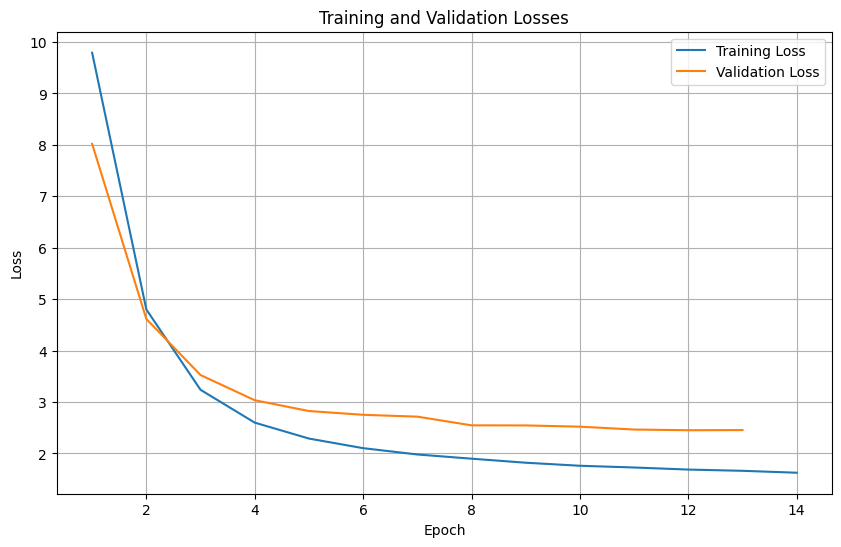


Training Summary:
Initial Training Loss: 9.7917
Final Training Loss: 1.6243
Best Training Loss: 1.6243

Initial Validation Loss: 8.0197
Final Validation Loss: 2.4538
Best Validation Loss: 2.4506


In [34]:

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.savefig("nrms_training_loss.png")
plt.show()

# Print final statistics
print("\nTraining Summary:")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Training Loss: {min(train_losses):.4f}")
print(f"\nInitial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")

## Evaluate the model

In [36]:
print(f"FRACTION: {FRACTION}, HISTORY_SIZE: {HISTORY_SIZE}")

# Filter out special Python attributes and print parameters
params = {k: v for k, v in hparams_nrms.__dict__.items() if not k.startswith('__')}
print("Hyperparameters:")
for key, value in params.items():
    print(f"{key}: {value}")

FRACTION: 0.2, HISTORY_SIZE: 50
Hyperparameters:
title_size: 300
embedding_dim: 32
word_emb_dim: 8
vocab_size: 10000
head_num: 32
head_dim: 192
attention_hidden_dim: 192
hidden_dim: 4
optimizer: adam
loss: cross_entropy_loss
dropout: 0.262803257540282
learning_rate: 1.0454050068420554e-05
weight_decay: 0.00016061208774452676
news_output_dim: 192
units_per_layer: [262, 84]
use_category: True
use_topic: True
use_numeric: False
use_session_discount: True
use_publication_discount: True
doc_out_dim: 128
cat_out_dim: 128
top_out_dim: 128
numeric_proj_dim: 16


In [37]:
def get_length_of_labels(df: pl.DataFrame, impression_id: int) -> int:
    # Filter for matching impression_id
    filtered = df.filter(pl.col('impression_id') == impression_id)
    
    if filtered.height == 0:
        raise ValueError(f"No row found for impression_id {impression_id}")
    
    # Get labels from first row
    labels = filtered.select('labels').row(0)[0]
    
    return len(labels)

In [38]:
# get_length_of_labels(df_validation, 349992000)

In [39]:
# Get first 5 labels
first_5_labels = df_validation.select('labels').head(5)

# Print each label with index
for i, row in enumerate(first_5_labels.iter_rows()):
    print(f"Label {i}: {row[0]}")

Label 0: [0, 0, 0, 0, 0, 0, 1, 0, 0]
Label 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Label 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Label 3: [0, 0, 1, 0, 0]
Label 4: [0, 0, 0, 1, 0]


In [40]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

# Initialize lists
all_predictions = []
all_labels = []
skipped_samples = 0

model.eval()
with torch.no_grad():
    for batch in val_dataloader_temp:
        inputs, targets, impression_ids = batch
        
        # Move to device
        inputs = [inp.to(device) for inp in inputs]
        
        # Get predictions
        predictions = model.predict(*inputs)
        
        # Convert to probabilities if needed
        if not torch.is_floating_point(predictions):
            predictions = torch.sigmoid(predictions)
        
        # Convert to lists while preserving structure
        batch_preds = predictions.cpu().numpy().tolist()
        batch_labels = targets.cpu().numpy().tolist()
        impression_ids = impression_ids.cpu().numpy().tolist()
        
        batch_preds_without_padding = []
        batch_labels_without_padding = []
        
        for pred_sample, label_sample, impression_id_sample in zip(batch_preds, batch_labels, impression_ids):
            # Remove padding
            actual_length = get_length_of_labels(df_validation, impression_id_sample)
            pred_sample = pred_sample[:actual_length]
            
            # Check if sample has both classes before adding
            if 1 in label_sample[:actual_length] and 0 in label_sample[:actual_length]:
                batch_preds_without_padding.append(pred_sample)
                batch_labels_without_padding.append(label_sample[:actual_length])
            else:
                skipped_samples += 1
        
        # Add batch predictions and labels
        all_predictions.extend(batch_preds_without_padding)
        all_labels.extend(batch_labels_without_padding)

print(f"Skipped {skipped_samples} samples with only one class")
print(f"Remaining valid samples: {len(all_predictions)}")

Skipped 0 samples with only one class
Remaining valid samples: 48639


In [43]:
# Initialize counters
correct_predictions = 0
total_samples = len(all_predictions)

# Iterate over samples
for idx, _ in enumerate(all_predictions):
    # print(f"Sample {idx}: Prediction: {all_predictions[idx]}")
    # print(f"Sample {idx}: Label:      {all_labels[idx]}")
    
    # Extract index of maximum value in predictions and labels
    pred_max_index = np.argmax(all_predictions[idx])
    label_max_index = np.argmax(all_labels[idx])
    
    # Compare indices to determine if the prediction was correct
    if pred_max_index == label_max_index:
        # print(f"Sample {idx}: Prediction was correct.")
        correct_predictions += 1
  #  else:
        # print(f"Sample {idx}: Prediction was wrong.")

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1764


In [44]:
from evaluation import AucScore

# auc_score = AucScore()

# auc_score.calculate(all_predictions, all_labels)
# print(f"AUC: {auc_score.score}")
# # Calculate AUC per sample
aucs = []
for preds, labels in zip(all_predictions, all_labels):
    try:
        # Only calculate if we have both positive and negative samples
        if sum(labels) > 0 and sum(labels) < len(labels):
            auc = roc_auc_score(labels, preds)
            aucs.append(auc)
    except ValueError:
        raise ValueError("Only one class present in labels. Cannot calculate AUC.")

print(f"\nMean AUC: {np.mean(aucs):.4f}")
print(f"Number of valid AUC calculations: {len(aucs)}")


Mean AUC: 0.6026
Number of valid AUC calculations: 48639


## Output Prediction File

## References

https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb